In [232]:
import jax.numpy as jnp
import numpy as np
import jax
import optax
import scipy
from scipy.spatial.distance import cdist
from scipy.integrate import RK45
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import equinox as eqx
import scipy.linalg
from jax.nn.initializers import variance_scaling
from jax.nn.initializers import he_normal
from tqdm import tqdm

seed = 42
np.random.seed(seed)
key = jax.random.key(seed)
batch_size = 64
num_branches = 20
num_trunk_epochs = 1000
num_branch_epochs = 1000
lr = 1e-5

print("\nconfiguring backend...")
jax.config.update("jax_platform_name", "metal")


print("backend selected:\n", jax.default_backend())
print("active devices:\n", jax.devices())
print("--------------------\n")


configuring backend...
backend selected:
 METAL
active devices:
 [METAL(id=0)]
--------------------



In [2]:
# Linear Model (Wx + b)
class Linear(eqx.Module):
    weight: jax.Array
    bias: jax.Array

    def __init__(self, in_size, out_size, key, initializer = he_normal()):
        wkey, bkey = jax.random.split(key)
        self.weight = initializer(wkey, (out_size, in_size), dtype=jnp.float32)
        self.bias = jnp.zeros((out_size,), dtype=jnp.float32)

    def __call__(self, x):
        return self.weight @ x + self.bias


# Basic MultiLayer Perceptron Primitive
class MLP(eqx.Module):
    layers: list
    activations: list

    def __init__(self, architecture, key, activation = jax.nn.relu, initializer = he_normal()):
        """
        architecture: List[in, hidden1, hidden2, ..., out]
        key: random key
        activation: jax.nn act fxn
        """
        keys = jax.random.split(key, len(architecture) - 1)
        self.layers = [
            Linear(architecture[i], architecture[i+1], keys[i], initializer = initializer) for i in range(len(architecture) - 1)]
        self.activations = [activation] * (len(self.layers) - 1) + [eqx.nn.Identity()] # no activation on last layer

    def __call__(self, x):
        for layer, act in zip(self.layers, self.activations):
            x = act(layer(x))
        return x

In [3]:
dataset = np.load('/Users/haydenoutlaw/Documents/Research/opnet/deep-operator-networks/data/burgers_dataset.npz', allow_pickle = True)
t_grid = jnp.array(dataset['t'])
x_grid = jnp.array(dataset['x'])
data = dataset['samples']
u = np.array([i['params'] for i in data])
s = np.array([i['solution'] for i in data])

n_samp = len(data)
train_indices, test_indices = train_test_split(np.arange(n_samp), test_size = 0.33, random_state = seed)
u_train, u_test = jnp.array(u[train_indices]), jnp.array(u[test_indices])
s_train, s_test = jnp.array(s[train_indices]), jnp.array(s[test_indices])


In [ ]:
xx, tt = jnp.meshgrid(x_grid,t_grid)
xt_grid = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)
print(xt_grid.shape)

ss_grid = s_train.reshape([-1, 40401]).T
print(ss_grid.shape)

(40401, 2)
(40401, 295)


In [ ]:
u_dim = 2 # in this case, two 
y_dim = 2 # (x,t)
# define architectures for component networks
branch_arch = [u_dim, 40, 40, num_branches] 
trunk_arch  = [y_dim, 40, 40, num_branches] 

key, subkey_t, subkey_A = jax.random.split(key, num=3)
trunk_model = MLP(trunk_arch,key = subkey_t)
A_model = jax.random.normal(subkey_A, (num_branches, s_train.shape[0]))

model = trunk_model, A_model

def deeponet_step1(model, u_tr):
    trunk_model, A_model = model
    trunk_mat = jax.vmap(trunk_model)(u_tr)
    return (trunk_mat @ A_model)

def loss_fn(model, u, s):
    pred_y = deeponet_step1(model,u)
    return jnp.sum((s - pred_y) ** 2)
    # return jnp.mean((s - pred_y) ** 2)

In [6]:
# equinox training step 
@eqx.filter_jit
def train_step(model, opt_state, x, y, opt_update):
    loss, grads = eqx.filter_value_and_grad(loss_fn)(model, x, y) # get loss and gradients
    updates, opt_state = opt_update(grads, opt_state, model) # update step
    model = eqx.apply_updates(model, updates) # apply updates
    return model, opt_state, loss


In [7]:
optim = optax.adam(lr)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

trunk_train_hist, trunk_test_hist = [],[]

print("beginning branch training...")
for epoch in tqdm(range(num_trunk_epochs)):
    
    model, opt_state, loss = train_step(model, opt_state, xt_grid, ss_grid, optim.update)

    trunk_train_hist.append(float(loss))



beginning branch training...


100%|██████████| 100000/100000 [24:25<00:00, 68.24it/s]


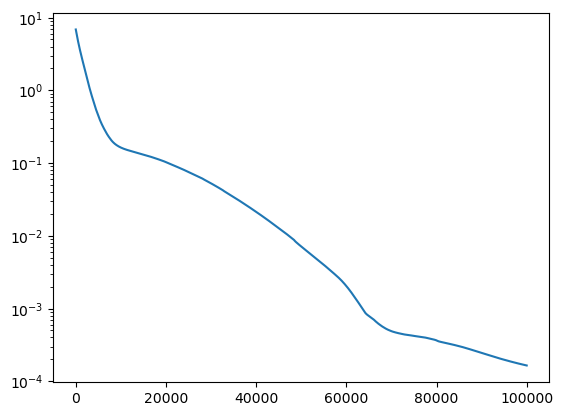

In [162]:
plt.figure()
plt.semilogy(trunk_train_hist)

In [8]:
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid))
Q,R = scipy.linalg.qr(trunk_mat, mode = 'economic')
T = scipy.linalg.inv(R.T)
print(np.linalg.matrix_rank(T))
print(np.linalg.matrix_rank(Q))

20
20


In [176]:
n_t, n_x = len(t_grid), len(x_grid)

# Reshape each orthogonalized function
orth_funcs = Q.reshape(n_t, n_x, -1)   # shape (nt, nx, num_branches)
print("orth_funcs shape:", orth_funcs.shape)  # (nt, nx, 40)

orth_funcs shape: (201, 201, 295)


In [177]:
"""
import matplotlib.pyplot as plt

num_funcs = orth_funcs.shape[-1]

fig, axes = plt.subplots(5, 4, figsize=(20, 12), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading='auto')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.show()

"""

'\nimport matplotlib.pyplot as plt\n\nnum_funcs = orth_funcs.shape[-1]\n\nfig, axes = plt.subplots(5, 4, figsize=(20, 12), constrained_layout=True)\nfor k, ax in enumerate(axes.flat):\n    if k < num_funcs:\n        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading=\'auto\')\n        ax.set_title(f"Q[{k}]")\n        ax.set_xlabel("x")\n        ax.set_ylabel("t")\nplt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)\nplt.show()\n\n'

In [178]:
## question is here
"""
RA_model =  (R @ A_model).T
key, subkey_b= jax.random.split(key, num=2)
branch_model = MLP(branch_arch,key = subkey_b)

u_train.shape == (295, u_dim)
RA_model.T.shape == (295, 20)


def deeponet_step2(branch_model, u_tr):
    branch_mat = jax.vmap(branch_model)(u_tr)
    return (branch_mat)

"""

'\nRA_model =  (R @ A_model).T\nkey, subkey_b= jax.random.split(key, num=2)\nbranch_model = MLP(branch_arch,key = subkey_b)\n\nu_train.shape == (295, u_dim)\nRA_model.T.shape == (295, 20)\n\n\ndef deeponet_step2(branch_model, u_tr):\n    branch_mat = jax.vmap(branch_model)(u_tr)\n    return (branch_mat)\n\n'

In [179]:
t_grid.shape

(201,)

In [180]:
xx, tt = jnp.meshgrid(x_grid,t_grid[100:101])
xt_grid_at_i = jnp.concatenate([xx.flatten()[:,None], tt.flatten()[:,None]], axis=1)

In [181]:
trunk_mat_at_i = np.array(jax.vmap(trunk_model)(xt_grid_at_i))
Q,R = scipy.linalg.qr(trunk_mat_at_i, mode = 'economic')

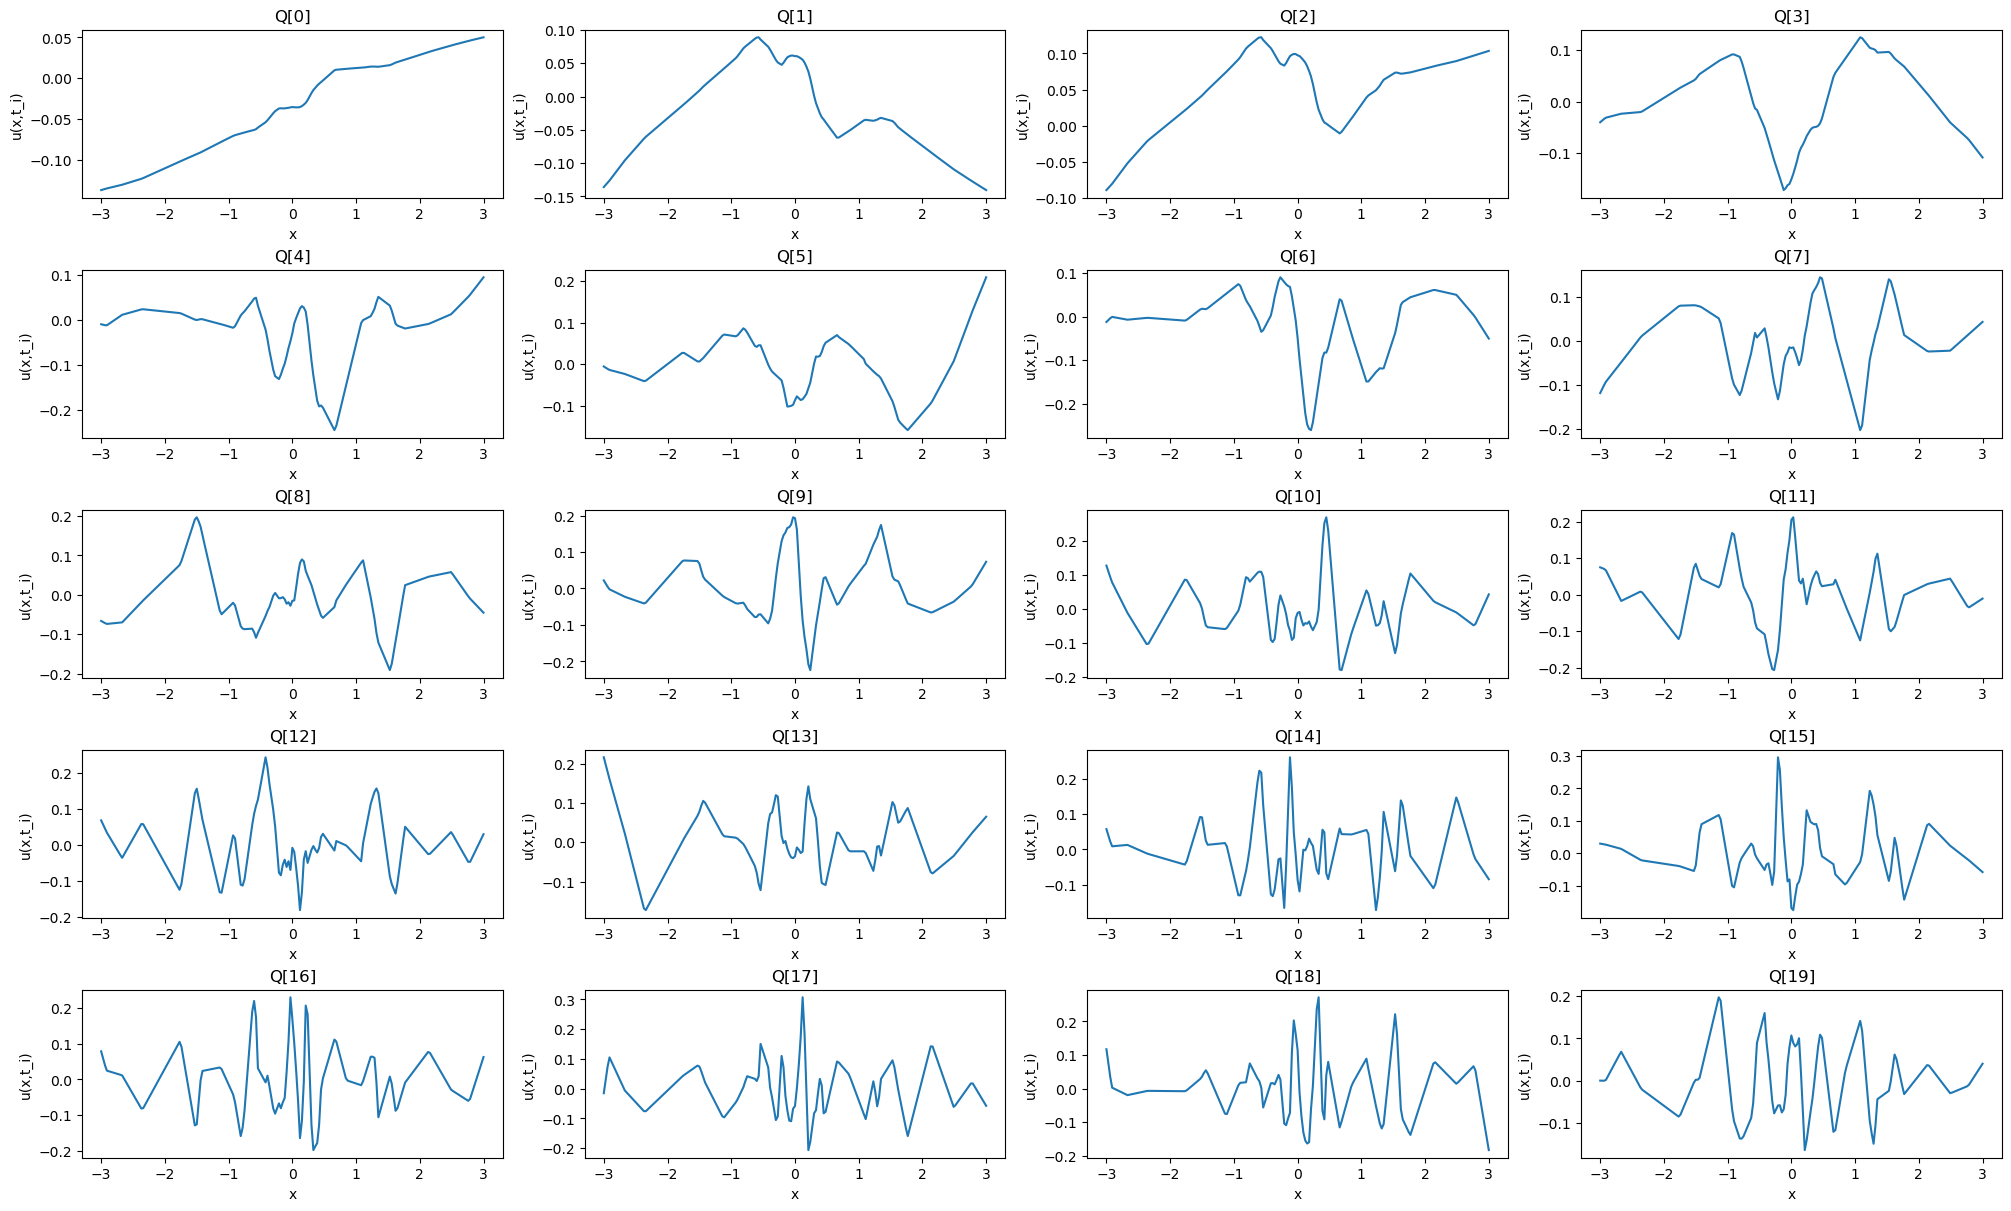

In [182]:
num_funcs = trunk_mat_at_i.shape[-1]

fig, axes = plt.subplots(5, 4, figsize=(20, 12), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        ax.plot(x_grid, Q[:,k])
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("u(x,t_i)")
# plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.show()



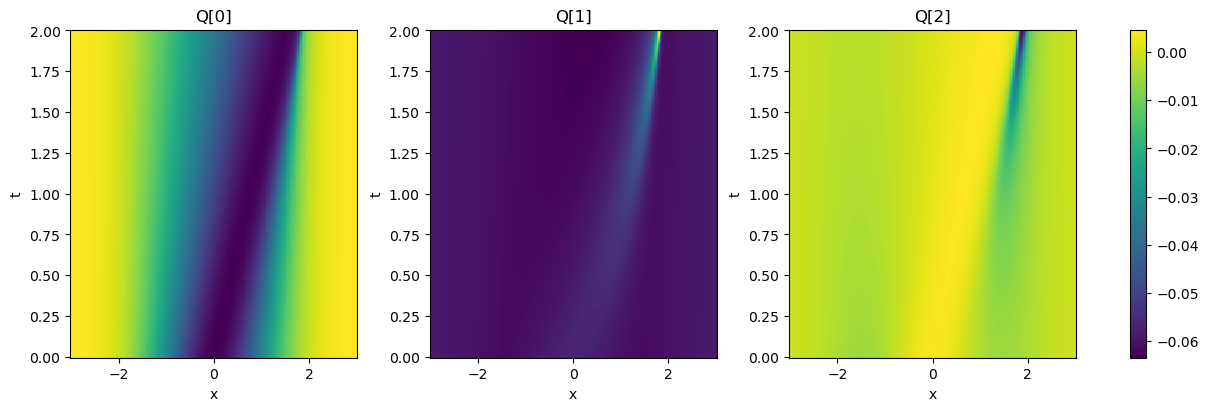

In [183]:
Q,R = scipy.linalg.qr(ss_grid, mode = 'economic')
orth_funcs = Q.reshape(n_t, n_x, -1)
num_funcs = 3

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
for k, ax in enumerate(axes.flat):
    if k < num_funcs:
        im = ax.pcolormesh(x_grid, t_grid, orth_funcs[:,:,k], shading='auto')
        ax.set_title(f"Q[{k}]")
        ax.set_xlabel("x")
        ax.set_ylabel("t")
plt.colorbar(im, ax=axes, orientation="vertical", fraction=0.02)
plt.show()



In [193]:
from scipy.linalg import interpolative as ip

np.linalg.matrix_rank(ss_grid)
U, s, Vh = scipy.linalg.svd(ss_grid)


In [231]:
truncated_rank = 48
# err = np.linalg.norm(ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])) )
err = np.sum((ss_grid - np.dot(U[:,:truncated_rank], (np.diag(s[:truncated_rank]) @ Vh[:truncated_rank,:])))**2)
print(f"err={err:.4e}")

err=1.5618e-03


In [224]:
deepOnet_err = np.linalg.norm(ss_grid - deeponet_step1(model, xt_grid))
print(f"deepOnet_err={deepOnet_err:.4e}")

deepOnet_err=4.4338e+01


In [221]:
# s.shape
len(np.where(s > 1e-4)[0])

48

for each time step:
- get X,t at time step
- pass through trained model
- take QR of model (at time t) -> Q_k R_k
- generate set of basis functions Ψ_k at time t_k (Q) by inverting R_k

don't use np.linalg rank methods! 

compare SVD method vs network basis functions for accuracy and expressiveness

## junked

In [152]:
# True reconstruction pipeline
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid))
Q, R = scipy.linalg.qr(trunk_mat, mode="economic")

# coefficients in Q-basis
RA_targets = (R @ np.array(A_model)).T   # (Ntrain, p)

# verify internal consistency
lhs = Q @ RA_targets.T                   # predicted field (Nxt, Ntrain)
rhs = trunk_mat @ A_model                # same thing via trunk_mat
diff = np.mean((lhs - rhs)**2)
print("Check Q @ RA_targets.T ≈ trunk_mat @ A_model :", diff)

# optional: compare with true data
Q_mse = np.mean((lhs - np.array(ss_grid))**2)
print("Reconstruction MSE vs true ss_grid:", Q_mse)


def loss_fn_2(model, u, y):
    pred = jax.vmap(model)(u)                # (Ntrain, p)
    return jnp.mean((y - pred)**2)


optim2 = optax.adam(1e-3)
opt_state2 = optim2.init(eqx.filter(branch_model, eqx.is_inexact_array))

@eqx.filter_jit
def train_step_2(model, opt_state, u, y):
    loss, grads = eqx.filter_value_and_grad(loss_fn_2)(model, u, y)
    updates, opt_state = optim2.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss

for epoch in tqdm(range(num_branch_epochs)):
    branch_model, opt_state2, loss = train_step_2(branch_model, opt_state2,
                                                 jnp.array(u_train),
                                                 jnp.array(RA_targets))
    if epoch % 100 == 0:
        print(f"Epoch {epoch:05d} | L2 Loss: {float(loss):.6e}")



Check Q @ RA_targets.T ≈ trunk_mat @ A_model : 2.5272581e-11
Reconstruction MSE vs true ss_grid: 6.857106


  5%|▍         | 49/1000 [00:00<00:03, 275.57it/s]

Epoch 00000 | L2 Loss: 1.334472e+04
Epoch 00100 | L2 Loss: 1.332465e+04


 25%|██▌       | 253/1000 [00:00<00:01, 466.91it/s]

Epoch 00200 | L2 Loss: 1.330376e+04


 35%|███▌      | 353/1000 [00:00<00:01, 483.93it/s]

Epoch 00300 | L2 Loss: 1.328430e+04
Epoch 00400 | L2 Loss: 1.326796e+04


 56%|█████▌    | 557/1000 [00:01<00:00, 492.65it/s]

Epoch 00500 | L2 Loss: 1.325276e+04


 66%|██████▌   | 656/1000 [00:01<00:00, 483.93it/s]

Epoch 00600 | L2 Loss: 1.324143e+04


 76%|███████▌  | 755/1000 [00:01<00:00, 485.73it/s]

Epoch 00700 | L2 Loss: 1.323392e+04


 86%|████████▌ | 858/1000 [00:01<00:00, 499.65it/s]

Epoch 00800 | L2 Loss: 1.322881e+04
Epoch 00900 | L2 Loss: 1.322543e+04


100%|██████████| 1000/1000 [00:02<00:00, 476.75it/s]


In [153]:


branch_mat = np.array(jax.vmap(branch_model)(u_test))
print(trunk_mat.shape)
print(T.shape)
print(branch_mat.shape)


full_mat = Q @ branch_mat.T


(40401, 20)
(20, 20)
(146, 20)


(201, 201)


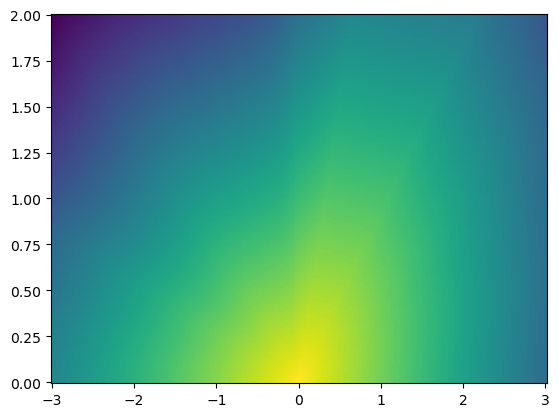

In [154]:
x_grid.shape

n_t, n_x = len(t_grid), len(x_grid)
# Example: plot the first sample
pred_field = full_mat[:, 0].reshape(n_t, n_x) # get 0th system
print(pred_field.shape)  # should be (n_t, n_x)


plt.pcolormesh(x_grid, t_grid, pred_field)


full_mat shape: (40401, 146)


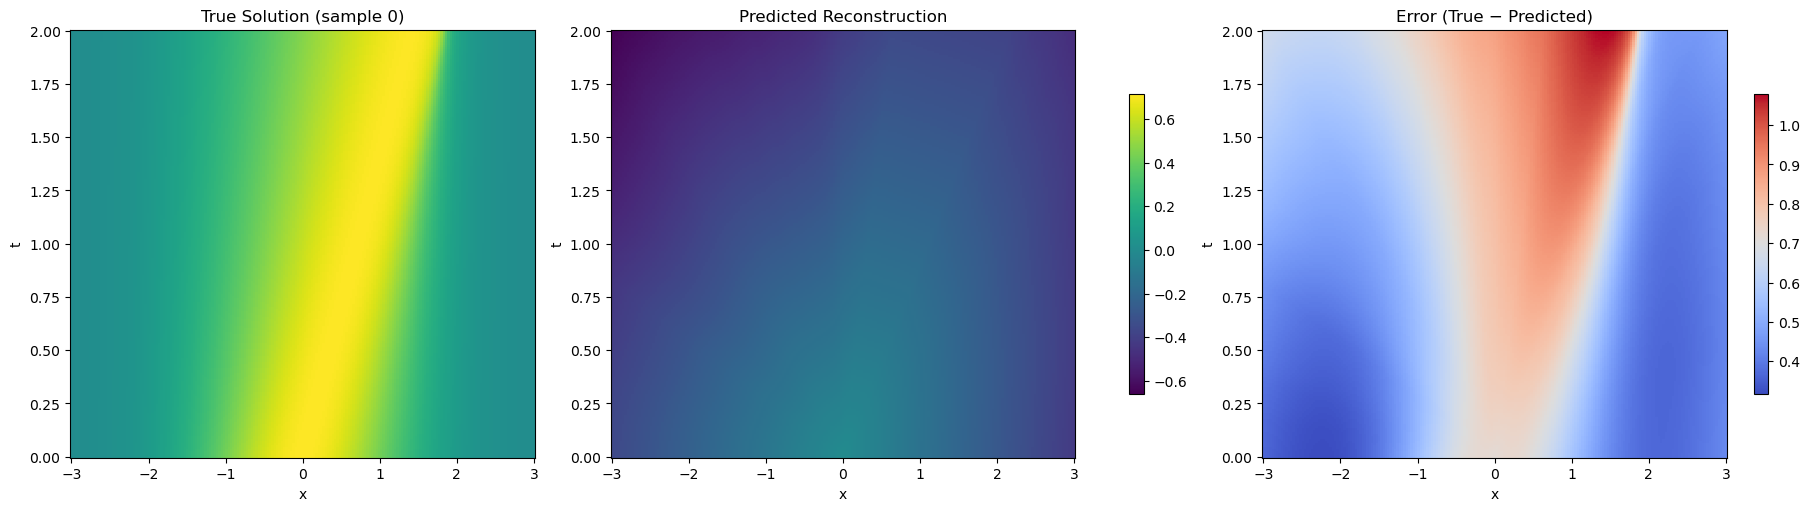

In [155]:

# --- Step 1. Evaluate trunk (basis functions) once on full grid ---
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid))     # (Nxt, p)
Q, R = scipy.linalg.qr(trunk_mat, mode="economic")       # orthonormal basis (Nxt,p)
n_t, n_x = len(t_grid), len(x_grid)

# --- Step 2. Predict coefficients for all test samples ---
branch_pred = np.array(jax.vmap(branch_model)(jnp.array(u_test)))   # (Ntest, p)

# --- Step 3. Reconstruct fields from coefficients ---
full_mat = Q @ branch_pred.T                     # (Nxt, Ntest)
print("full_mat shape:", full_mat.shape)

# --- Step 4. Pick one or more samples to visualize ---
sample_idx = 0  # change this to view different test samples

pred_field = full_mat[:, sample_idx].reshape(n_t, n_x)
true_field = np.array(s_test[sample_idx])        # (n_t, n_x)

# --- Step 5. Compute and visualize ---
vmin = min(true_field.min(), pred_field.min())
vmax = max(true_field.max(), pred_field.max())

fig, axes = plt.subplots(1, 3, figsize=(18, 5), constrained_layout=True)

# True solution
im1 = axes[0].pcolormesh(x_grid, t_grid, true_field, shading="auto",
                         vmin=vmin, vmax=vmax, cmap="viridis")
axes[0].set_title(f"True Solution (sample {sample_idx})")
axes[0].set_xlabel("x")
axes[0].set_ylabel("t")

# Predicted reconstruction
im2 = axes[1].pcolormesh(x_grid, t_grid, pred_field, shading="auto",
                         vmin=vmin, vmax=vmax, cmap="viridis")
axes[1].set_title("Predicted Reconstruction")
axes[1].set_xlabel("x")
axes[1].set_ylabel("t")

# Error surface
err = true_field - pred_field
im3 = axes[2].pcolormesh(x_grid, t_grid, err, shading="auto",
                         cmap="coolwarm")
axes[2].set_title("Error (True − Predicted)")
axes[2].set_xlabel("x")
axes[2].set_ylabel("t")

# Colorbars
fig.colorbar(im1, ax=axes[:2], orientation="vertical", shrink=0.7, location="right")
fig.colorbar(im3, ax=[axes[2]], orientation="vertical", shrink=0.7, location="right")
plt.show()


True field stats: min=6.287e-03, max=7.150e-01


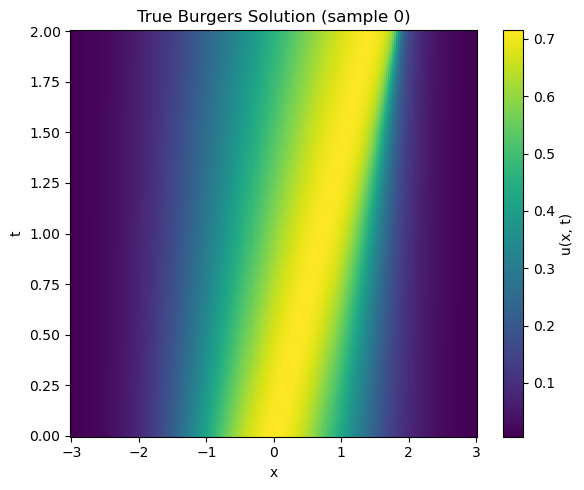

In [156]:
# %%
# --- Plot the true solution for one test sample ---

sample_idx = 0  # choose which test sample to visualize
true_field = np.array(s_test[sample_idx])  # shape (201, 201)

print(f"True field stats: min={true_field.min():.3e}, max={true_field.max():.3e}")

plt.figure(figsize=(6, 5))
plt.pcolormesh(x_grid, t_grid, true_field, shading='auto', cmap='viridis')
plt.title(f"True Burgers Solution (sample {sample_idx})")
plt.xlabel("x")
plt.ylabel("t")
plt.colorbar(label="u(x, t)")
plt.tight_layout()
plt.show()


In [157]:
# Evaluate the (trained) trunk on the SAME grid used in training
trunk_mat = np.array(jax.vmap(trunk_model)(xt_grid))     # (Nxt, num_branches)

# Reconstruct training fields via learned A_model (pre-QR)
recon_preQR = trunk_mat @ np.array(A_model)              # (Nxt, Ntrain)
preQR_mse = np.mean((recon_preQR - np.array(ss_grid))**2)
print("Pre-QR recon MSE (should be small-ish):", preQR_mse)


Pre-QR recon MSE (should be small-ish): 6.8571005


In [158]:
# Orthogonalize trunk_mat and transform A_model -> RA (targets for branch)
Q, R = scipy.linalg.qr(trunk_mat, mode="economic")       # Q: (Nxt, p), R: (p, p)
RA_targets = (R @ np.array(A_model)).T   # (Ntrain, p)

# Using Q and RA_targets must exactly reproduce ss_grid if everything aligns:
recon_Q = Q @ RA_targets.T                                # (Nxt, Ntrain)
Q_mse = np.mean((recon_Q - np.array(ss_grid))**2)
print("Q-basis recon MSE on TRAIN (should match pre-QR MSE):", Q_mse)


Q-basis recon MSE on TRAIN (should match pre-QR MSE): 6.857106


In [159]:
# Branch fit quality on TRAINING set
branch_train = np.array(jax.vmap(branch_model)(u_train))   # (Ntrain, p)
branch_mse = np.mean((branch_train - RA_targets)**2)
print("Branch TRAIN MSE vs RA_targets (should be small):", branch_mse)

# Quick parity check for a few components
for k in range(min(3, branch_train.shape[1])):
    corr = np.corrcoef(branch_train[:,k], RA_targets[:,k])[0,1]
    print(f"Corr(branch[:,{k}], RA_targets[:,{k}]): {corr:.3f}")


Branch TRAIN MSE vs RA_targets (should be small): 13222.582
Corr(branch[:,0], RA_targets[:,0]): 0.137
Corr(branch[:,1], RA_targets[:,1]): 0.120
Corr(branch[:,2], RA_targets[:,2]): 0.122
